In [1]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import scipy.integrate as integrate
import scipy.special as special

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

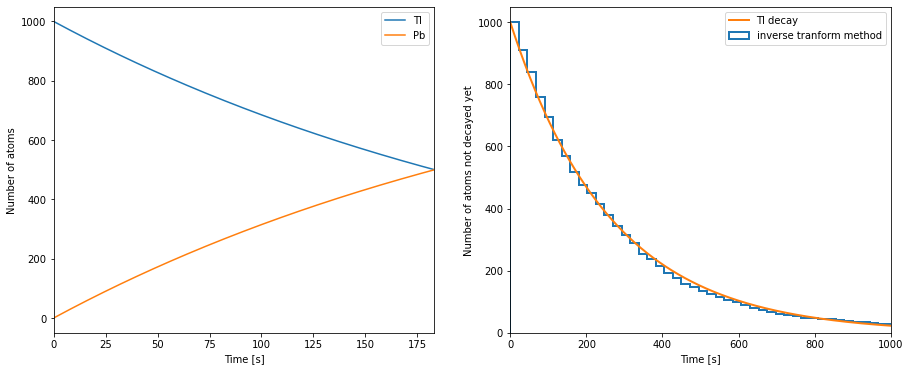

In [2]:
def cdf(t,tau):
    return 1-2**(-t/tau)

def pdf(t,tau):
    return 2**(-t/tau)*np.log(2)/tau

def icdf(z,tau):
    return -tau*math.log2(1-z)
    

tau = 3.052*60 # in second
th_atoms = 1000
pb_atoms = 0
time_end = 1000
th_array = np.zeros(time_end)
pb_array = np.zeros(time_end)
for i in range(0,time_end):
    temp = th_atoms*cdf(i,tau)
    th_array[i] = th_atoms-temp
    pb_array[i] = pb_atoms+temp

time = np.linspace(0,time_end,time_end)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6), squeeze=False)
ax[0,0].plot(time[0:200],th_array[0:200], label = "Tl")
ax[0,0].plot(time[0:200],pb_array[0:200], label = "Pb")
ax[0,0].set_ylabel("Number of atoms")
ax[0,0].set_xlabel("Time [s]")
ax[0,0].legend(loc='best')
ax[0,0].axis(xmin = 0,xmax = tau)


u = np.random.random(1000)
icdf2 = np.vectorize(icdf)
v = icdf2(u,tau)
ax[0,1].hist(v, histtype='step', cumulative = -1, bins=100, linewidth=2,label = 'inverse tranform method')
ax[0,1].plot(time,th_array, linewidth=2, label = 'Tl decay')
ax[0,1].set_ylabel("Number of atoms not decayed yet")
ax[0,1].set_xlabel("Time [s]")
ax[0,1].axis(xmin = 0,xmax = 1000)
ax[0,1].legend(loc='best')
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [3]:
a0 = 5.291777721092e-11
e0 = 8.85418781762e-12
st = a0 / 100
Z = 79
n = int(1e6)
elec =  -1.60217663e-19 # electron charge
E = abs(7.7e6*elec)

z = np.random.random(n)
th = 2*np.pi*np.random.random(n)
r_squared = -2*np.log(z)
r = np.sqrt(r_squared)
x = r*np.cos(th)*st
y = r*np.sin(th)*st

count = 0;
for i in range(0,n):
    b = math.sqrt(x[i]**2+y[i]**2)
    theta = 2*np.arctan((Z*elec**2)/(2*np.pi*e0*E*b))
    if (theta > np.pi/2):
        count += 1
    
        
print("The fraction of particles that bounce back is ",count/n*100,'%')

The fraction of particles that bounce back is  0.1527 %


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [5]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2


result = integrate.quad(f, 0, 2)
true = result[0]
print('true value',true)

# Monte Carlo integration
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print('hit/miss method','\n','value',I)

error = abs(true-I)/true
print('error',error)

sum_value = 0
for i in range(N):
    x=2*np.random.random()
    sum_value = f(x)+sum_value

I2 = 2*sum_value/N        
print('mean value method','\n','value',I2)

error2 = abs(true-I2)/true
print('error',error2)    
print('The most of the times the mean value method gives a better estimation')

<ipython-input-5-4febb344b9c9>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(f, 0, 2)


true value 1.4516877509810684
hit/miss method 
 value 1.45634
error 0.003204717416529504
mean value method 
 value 1.4532704015960483
error 0.0010902142102599468
The most of the times the mean value method gives a better estimation


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [6]:
def f(x,y):
    if (x**2+y**2 > 1):
        return 0
    return 1

def fn(x):
    distance = np.linalg.norm(x)
    if distance > 1.0:
        return 0
    return 1

N=100000
sum_value = 0
for i in range(N):
    x=np.random.random()
    y = np.random.random()
    sum_value = f(x,y)+sum_value    

I = 4*sum_value/N   # 4 quadrants
print('Area of circle')
print('value',I)    
error = abs(math.pi-I)/math.pi
print('error',error)

D = 10 # dimension
sum_value = 0
for i in range(N):
    x = np.random.random(D)
    sum_value = fn(x)+sum_value    

I = 2**D*sum_value/N   
true_volume = np.pi**(D // 2) / math.factorial(D // 2)
print('Volum of',D,'D sphere')
print('value',I)    
error = abs(true_volume-I)/true_volume
print('error',error)

Area of circle
value 3.1362
error 0.0017165349503956255
Volum of 10 D sphere
value 2.39616
error 0.06038985628734382


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [7]:
def f(x):
    return x**(-1/2)/(math.exp(x)+1)

def w(x):
    return 1/math.sqrt(x)

I_true = integrate.quad(f, 0, 1)
p = integrate.quad(w, 0, 1)
print('true value',I_true[0])
N=100000
sum_value = 0
for i in range(N):
    x=np.random.random()
    sum_value = sum_value+f(x)/w(x)*p[0]
    
I = (sum_value/N)   
error = abs(I_true[0]-I)/I_true[0]
print('Monte Carlo integration with importance sampling')
print('(',I,',',error,')')        

sum_value = 0
for i in range(N):
    x=np.random.random()
    sum_value = sum_value+f(x)
I = sum_value/N    
error = abs(I_true[0]-I)/I_true[0]
print('Monte Carlo integration without importance sampling')
print('(',I,',',error,')')      

true value 0.8389329600133792
Monte Carlo integration with importance sampling
( 0.7598473321181777 , 0.094269305969264 )
Monte Carlo integration without importance sampling
( 0.8354709055211242 , 0.004126735576344257 )
